In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io.wavfile as wav
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import glob
import math
import torch.nn as nn
import numpy as np
from bisect import bisect_left
import scipy as sp
import h5py
from scipy.io import wavfile
from glob import glob


In [2]:


fs = 16000

config = {
"continue_training_from_checkpoint" : "../models/new_type_dataset_medium_sage-shadow-58_100.pth",
"dropout" : 0.1,
"batch_size" : 30, 
"max_shift" : 500, # ~10 meters
"guess_grid_size" : 100,
"dataset" : "new_type_dataset_medium.hdf5",
"cnn_output_size_at_factor_1" : 576,
"factor" : 10,
"loss_fn" : "cross_entropy",
"epochs" : 1000,
"sample_length" : 10000,
"lr" : 3e-5,
"n_batch_before_print" : 3,
"max_freq" : 2500,
"rir_len" : 1600,
"rooms_per_batch" : 30,
"mics_per_batch" : 15,
"warmup_steps_per_epoch" : 5,
"warmup_epochs" : 2,
}

device = "cpu" #'cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

class Block(nn.Module):
    def __init__(self,size):
        super().__init__()
        self.dropout = nn.Dropout(config["dropout"])
        self.l = nn.Linear(size,2*size)
        self.l2 = nn.Linear(2*size,size)
        self.act = nn.GELU()
        self.ln = nn.LayerNorm(size)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.002)
            
    def forward(self, x):
        return x + self.l2(self.act(self.l(self.ln(self.dropout(x)))))

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.thinker = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["factor"]*config["cnn_output_size_at_factor_1"],1000),
            nn.GELU(),
            #Block(1000),
            #Block(1000),
            nn.Linear(1000,config["guess_grid_size"])
        )
        
        self.apply(self._init_weights)
        
        self.cnn = nn.Sequential(
            nn.Conv1d(4,48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 50,stride=5),
            nn.GELU(),
            nn.Conv1d(48*config["factor"],48*config["factor"], 30,stride=5),
            nn.GELU(),
            nn.Flatten(),
        )
        
        
        

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.00002)
        
                
    def forward(self, x):
        x = self.cnn(x)
        x = self.thinker(x)
        return x
    
model = Classifier().to(device)
if config["continue_training_from_checkpoint"]:
    model = torch.load(config["continue_training_from_checkpoint"],map_location=torch.device('cpu'))

def y_to_class_gt(y, guess_grid_size, max_shift) :
    y[y.abs() > max_shift] = max_shift*y[y.abs() > max_shift].sign()

    bin_width = max_shift*2/guess_grid_size
    y = (y/bin_width).round() + guess_grid_size // 2 
    y[y == guess_grid_size] = guess_grid_size - 1
    return y.long()

FileNotFoundError: [Errno 2] No such file or directory: '../models/new_type_dataset_medium_sage-shadow-58_100.pth'

[1.4806489  0.92741096 0.24293928]


NameError: name 'y_to_class_gt' is not defined

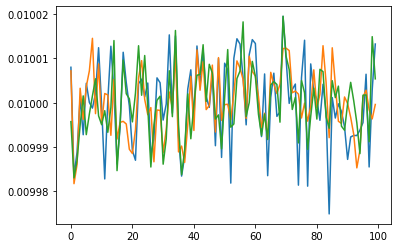

In [3]:
data = "../datasets/music_0014_tdoa_test_data.hdf5"
data = "../datasets/music_0014_tdoa_test_data.hdf5"

with h5py.File(data, 'r') as hdf5_file:
    X = hdf5_file['input']
    y = hdf5_file['gt']

    b = 800
    indx = np.arange(b,b+3)
    pred = model(torch.tensor(X[indx]/1e5))

    plt.plot(pred.softmax(1).T.detach())
    print(y[indx])
    y = y_to_class_gt(torch.tensor(y[indx])*fs/343, config["guess_grid_size"], config["max_shift"]).to(torch.long)
    print(y)
    

In [48]:
sound_paths = glob("../datasets/reference_sounds/*.wav")
sound_path = sound_paths[np.random.randint(len(sound_paths))]
fs,signal = wavfile.read(sound_path)

In [29]:
data = "../datasets/music_0014_tdoa_test_data.hdf5"
with h5py.File(data, 'r') as hdf5_file:
    X = hdf5_file['input']
    y = hdf5_file['gt']
    

[[-2.3704082e+09 -1.9501595e+09 -2.7759437e+09 ...  3.9353062e+08
  -2.1336433e+09 -2.1809293e+08]
 [ 1.4014932e+09  1.1864605e+09  6.3230458e+08 ...  3.6939840e+08
  -9.4841101e+08  8.5784102e+08]
 [ 0.0000000e+00  1.2535622e+09  5.4523187e+09 ... -1.0300396e+09
  -7.6547622e+08  6.5776179e+08]
 [ 0.0000000e+00  5.2292710e+09  2.9334405e+09 ... -7.2969658e+08
  -1.4283661e+08  2.9391530e+08]]


In [34]:
data = "../datasets/generated_dataset/generated_dataset_medium.hdf5"
with h5py.File(data, 'r') as hdf5_file:
    X = hdf5_file['input']
    y = hdf5_file['gt']
    print(X[1000])

[[[ 1.51491602e+03  9.92211426e+03]
  [ 1.51290076e+03  9.92303027e+03]
  [ 1.54681360e+03  9.93625781e+03]
  ...
  [-1.62904712e+03 -7.61825293e+03]
  [-1.59018145e+04  7.24654297e+04]
  [ 2.03095020e+04 -7.84097812e+04]]

 [[-0.00000000e+00 -0.00000000e+00]
  [ 3.93271446e+01  1.78216293e+02]
  [ 1.27115395e+02  3.57735565e+02]
  ...
  [ 1.08752051e+04 -5.77264258e+04]
  [-2.44154434e+04  5.11419688e+04]
  [ 5.10037744e+03 -4.42206689e+03]]]
